In [2]:
# WEEDMAPS DATA CLEANING: BUSINESS-LEVEL DATA
# - create indicators for whether we have medical / recreational license info
# - create indicators for descriptors (e.g. in-store purchases only, order online, medical and recreational etc)
# - create variable for state that dispensary is located in
# - split license variable into medical and recreational licenses (INCOMPLETE)


# Imports
import pandas as pd
import os
import re
from pyzipcode import ZipCodeDatabase


In [3]:
zcdb = ZipCodeDatabase()

In [4]:
# Import business-level data
df = pd.read_csv("../stores_data.csv")

Create indicators for medical / recreational license


In [5]:
cats = ["Medical", "Adult-Use"]
for cat in cats:
    df[cat + "_ID?"] = df["Licenses"].str.contains(cat, case = False).astype(float)

Create indicator variables based on descriptors

In [6]:
df2 = df.copy()
df2["Descriptors"] = df2.apply(lambda row : "|".join([x.strip() for x in row["Descriptors"].split("|")]),
                             axis = 1)

In [7]:
df_desc2 = df2.Descriptors.str.get_dummies()

In [8]:
df3 = df2.join(df_desc2)

Create state variable

In [9]:
states =["Alabama", "Alaska", "Arizona", "Arkansas", "California", 
             "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", 
             "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", 
             "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", 
             "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", 
             "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", 
             "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", 
             "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
             "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", 
             "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

# function to check which state a dispensary is in
def get_state(col_val):
    col_val = col_val.split(",")[-1]
    state_val = None
    for state in states:
        st = state.lower() + " "
        if st in col_val.lower():
            state_val = state
            break
    return state_val

In [10]:
# applying function to dataframe
df4 = df3.copy()
df4["State"] = df4.apply(lambda row : get_state(row["Address"]),
                             axis = 1)

In [11]:
# businesses with 2 potential state names in their address (currently 167)
dftest = df4[~df4.State.isna()]
df_amb = dftest[dftest.State.map(len) > 1]
len(df_amb)

5217

In [12]:
# businesses which are likely not based in any of the 50 US states (currently 1480)
df_no_state = df4[df4["State"].isna()]
len(df_no_state)

1484

In [13]:
# testing
test = df.Descriptors[0]
test2 = df2.Descriptors[0]
test2
test

'Dispensary | Order online | Recreational | Supports the Black community'

In [14]:
test = df.Address[0]
test

'436 N Clark Street, Chicago, Illinois 60654'

In [16]:
df4['Medical Store?'] = df4[['Medical', 'Medical & Recreational', 'Medicinal & Recreational']].apply(lambda s : s > 0).any(axis = 1)
df4['Recreational Store?'] = df4[['Recreational', 'Medical & Recreational', 'Medicinal & Recreational']].apply(lambda s : s > 0).any(axis = 1)
df4 = df4.drop(['Medical', 'Recreational', 'Medical & Recreational', 'Medicinal & Recreational', 'Descriptors'], axis = 1).rename({"Name" : "Store Name"}, axis = 1)

In [17]:
df4.drop("Url", axis = 1).to_csv("../stores_data_clean.csv")

In [19]:
# Read in products data and merge in location and dispensary name information
import pandas as pd
products = pd.concat([pd.read_csv(f"../products_data_cleaned/part_{i}.csv") for i in range(1, 11)]).drop_duplicates().reset_index(drop = True)
products = products.merge(df4, left_on='url', right_on = "Url", how = 'inner').query("State == State").reset_index(drop = True)

In [ ]:
#save merged products information

output_directory = 'products_data_final/'
os.mkdir(output_directory)

# Calculate the number of rows per part
num_rows = len(products)
rows_per_part = num_rows // 10

# Split the CSV into 10 parts
for i in range(10):
    start_idx = i * rows_per_part
    end_idx = start_idx + rows_per_part
    if i == 9:
        end_idx = num_rows
    part_df = products.drop("Url", axis = 1).iloc[start_idx:end_idx]
    
    # Save each part to a separate CSV file
    output_file = os.path.join(output_directory, f'part_{i+1}.csv')
    part_df.to_csv(output_file, index=False)

In [20]:
#Code to normalize from percent THC to mg of THC

test = products.query("thc != 'None' & price != 'None' & weight != 'None'")
test = test[test['thc'].str.contains("%")]
test['thc'] = test['thc'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))
test['weight'] = test['weight'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))
test['thc'] = test['thc'] * test['weight'] / 100000
test['price'] = test['price'].apply(lambda s : float(s[1:]))

In [21]:
#read in information related to legalization dates and tax rates, drop states without legal sales yet

legalization = pd.read_csv("../legalization_data.txt").set_index("state").drop(['DC', 'Virginia', 'Delaware', 'Minnesota', 'Ohio'])
legalization.loc['Nevada', "tax_rate"] = "15%"
legalization["legalization_date"] = legalization['legalization_date'].astype('datetime64[m]')
legalization["licensed_sales_since_date"] = legalization['licensed_sales_since_date'].astype('datetime64[m]')
legalization['tax_rate'] = legalization['tax_rate'].apply(lambda s : float(s[:-1]))
legalization

,legalization_date,licensed_sales_since_date,tax_rate
state,,,
Washington,2012-12-06,2014-07-08,37%
Colorado,2012-12-10,2014-01-01,15%
Alaska,2015-02-24,2016-10-29,$50/ounce
Oregon,2015-07-01,2015-10-01,17%
California,2016-11-09,2018-01-01,15%
Massachusetts,2016-12-15,2018-11-20,10.75%
Nevada,2017-01-01,2017-07-01,15%
Maine,2017-01-30,2020-10-09,10%
Vermont,2018-07-01,2022-10-01,14%


Linear Model: Slope : [19.22465486], Intercept : 29.951533139589 R^2 : 0.3339692957392737
Linear Model: Slope : [31.73751309], Intercept : 30.89732807599406 R^2 : 0.7016735261672764
Linear Model: Slope : [32.52098991], Intercept : 16.0958333684746 R^2 : 0.8249944845652468
Linear Model: Slope : [25.2354975], Intercept : 35.70549044054441 R^2 : 0.5813706661645874
Linear Model: Slope : [10.5140141], Intercept : 23.72745358021243 R^2 : 0.4754844757266675
Linear Model: Slope : [13.42511443], Intercept : 10.370817528709217 R^2 : 0.4768324320906284


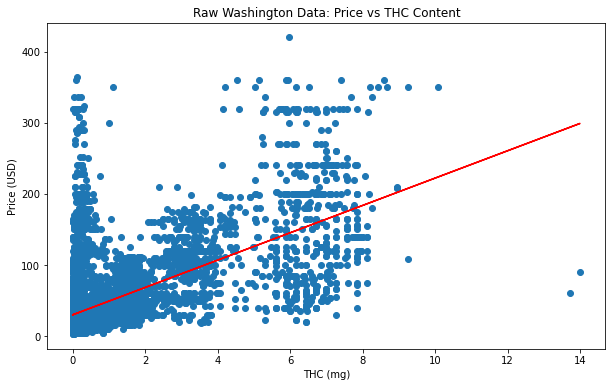

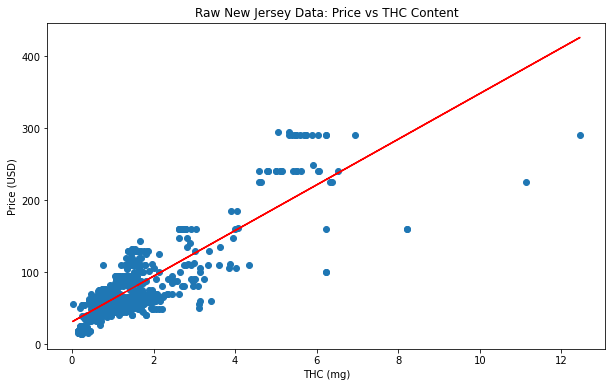

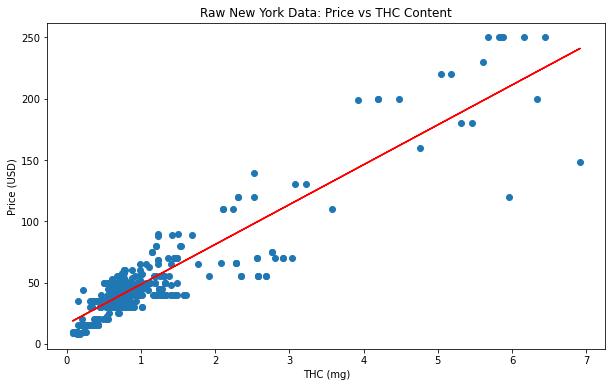

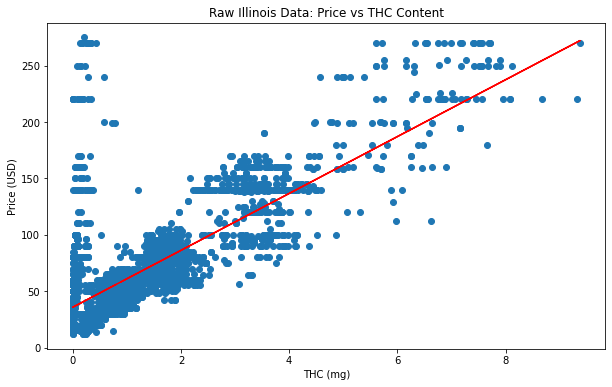

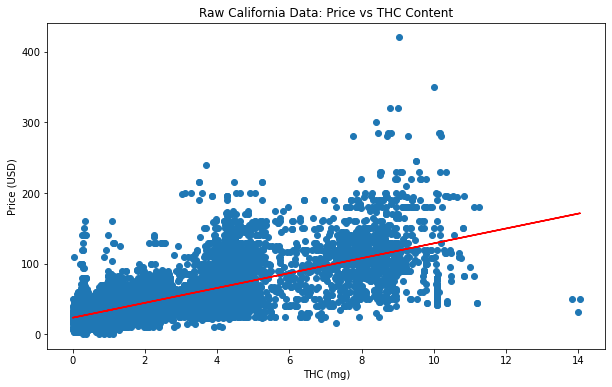

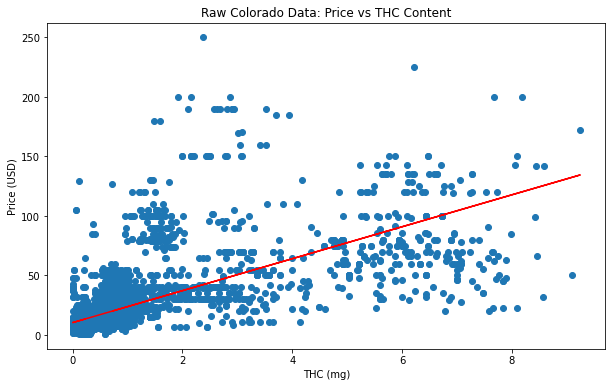

In [24]:
# regressions for THC vs price for Flower products for selected states

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

for state in ['Washington', 'New Jersey', 'New York', 'Illinois', 'California', 'Colorado']:
    test2 = test.query(f"category == 'FLOWER' & State == '{state}' & thc < 15 & price < 500")
    data = test2[['thc', 'price']].to_numpy()
    data_x = data[:, 0]
    data_y = data[:, 1]
    model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
    print(f"Linear Model: Slope : {model.coef_}, Intercept : {model.intercept_} R^2 : {model.score(data_x.reshape((-1, 1)), data_y)}")

    plt.figure(figsize=(10, 6))
    plt.scatter(data_x ,data_y)
    plt.plot(data_x, model.intercept_ + model.coef_ * data_x, 'r')
    plt.title(f"Raw {state} Data: Price vs THC Content")
    plt.xlabel("THC (mg)")
    plt.ylabel("Price (USD)")
    plt.savefig(f"../figures/{state.replace(' ', '_').lower()}_raw_regression.png", format = 'png', dpi = 300)

In [25]:
# Run above regression on all states, save results in a dataframe

results = []
for state in legalization.index:
    data = test.query(f"category == 'FLOWER' & State == '{state}' & price < 500 & thc < 15000")[['thc', 'price']].to_numpy()
    data_x = data[:, 0]
    data_y = data[:, 1]
    model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
    results.append({"Number of Data Points" : data_x.shape[0], "state" : state, "intercept" : model.intercept_, "slope" : model.coef_[0], "R^2" : model.score(data_x.reshape((-1, 1)), data_y)})

results_df = pd.DataFrame(results).set_index("state").join(legalization)

#for results including tax rates, drop states with irregular tax regimes
results_df_tax = results_df.drop(['Alaska', 'Illinois', 'Connecticut', 'New Jersey', 'Maryland'])
results_df_tax['tax_rate'] = results_df_tax['tax_rate'].apply(lambda s : float(s[:-1]))

0.342377567644748


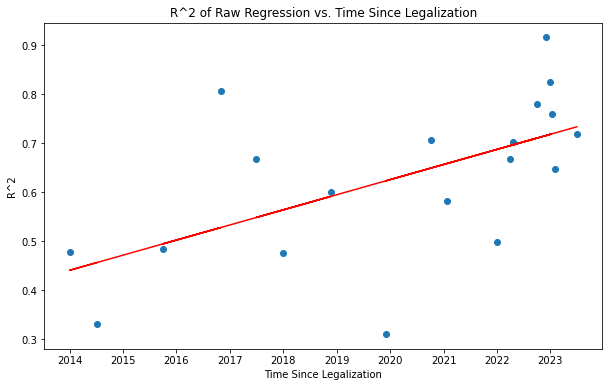

In [29]:
#regress R^2 vs Time Since Legalized Sales Began

data_x = results_df['licensed_sales_since_date'].astype("int64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df['R^2'])

plt.figure(figsize = (10, 6))
plt.scatter(results_df['licensed_sales_since_date'], results_df['R^2'])
plt.plot(results_df['licensed_sales_since_date'], model2.predict(data_x), 'r')
plt.title("R^2 of Raw Regression vs. Time Since Legalization")
plt.xlabel("Time Since Legalization")
plt.ylabel("R^2")
plt.savefig("../figures/r2_vs_time_raw.png", format = 'png', dpi = 300)
print(model2.score(data_x, results_df['R^2']))
plt.show()


0.024880418870332988


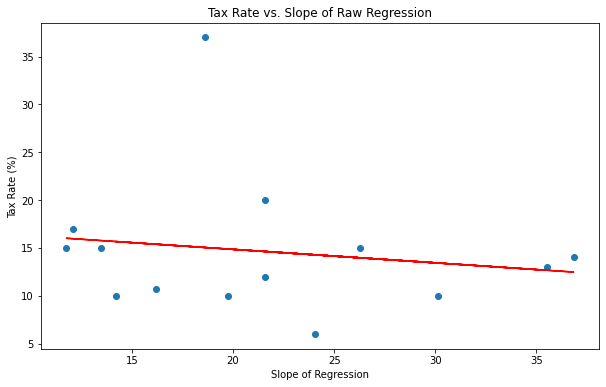

In [113]:
#regression Tax Rate vs. Slope of Regression

data_x = results_df_tax['slope'].astype("float64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df_tax['tax_rate'])


plt.figure(figsize = (10, 6))
plt.scatter(data_x, results_df_tax['tax_rate'])
plt.plot(data_x, model2.predict(data_x), 'r')
plt.title("Tax Rate vs. Slope of Raw Regression")
plt.xlabel("Slope of Regression")
plt.ylabel("Tax Rate (%)")
plt.savefig("../figures/slope_vs_tax_raw.png", format = 'png', dpi = 300)
print(model2.score(data_x, results_df_tax['tax_rate']))
plt.show()


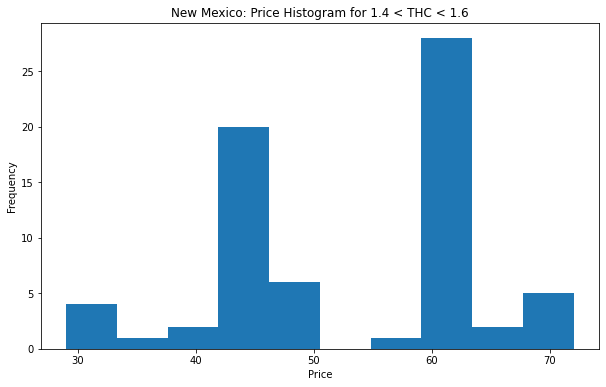

In [112]:
# Look at spread of prices for a fixed slice of THC content

state = "New Mexico"
test2 = test.query(f"category == 'FLOWER' & State == '{state}' & thc < 15 & price < 100")
slice = 1.4

plt.figure(figsize = (10,6))
plt.hist(test2[(slice <= test2['thc']) & (test2['thc'] < slice + 0.2)]['price'])
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("New Mexico: Price Histogram for 1.4 < THC < 1.6")
plt.savefig("../figures/new_mexico_raw_hist.png", format = 'png', dpi = 300)
plt.show()

#test2[(slice <= test2['thc']) & (test2['thc'] < slice + 0.2) & (test2['price'] > 100)]

# # with new mexico:
# slice = 2500
# plt.hist(test2[(slice <= test2['thc']) & (test2['thc'] < slice + 200)]['price'])
# test2[(slice <= test2['thc']) & (test2['thc'] < slice + 200) & (test2['price'] < 100)]

Linear Model: Slope : [18.60919798], Intercept : 30.54946566891673 R^2 : 0.3212663307729876


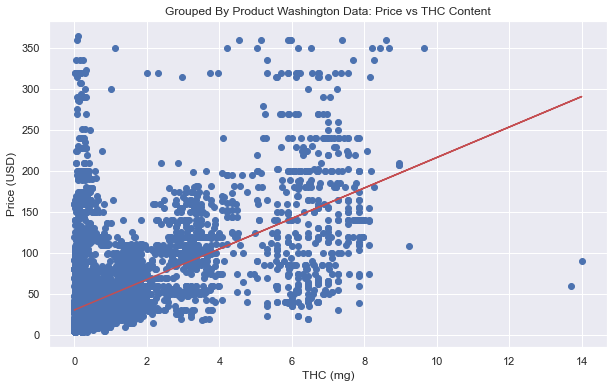

In [94]:
#Re-running all regressions with the added step of grouping by product name and averaging out the THC content and price

for state in ['Washington']:
    test3 = test.query(f"category == 'FLOWER' & State == '{state}' & thc < 15 & price < 500")[['name', 'thc', 'price']].groupby("name").mean()
    data = test3.to_numpy()
    data_x = data[:, 0]
    data_y = data[:, 1]
    model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
    print(f"Linear Model: Slope : {model.coef_}, Intercept : {model.intercept_} R^2 : {model.score(data_x.reshape((-1, 1)), data_y)}")

    plt.figure(figsize=(10, 6))
    plt.scatter(data_x ,data_y)
    plt.plot(data_x, model.intercept_ + model.coef_ * data_x, 'r')
    plt.title(f"Grouped By Product {state} Data: Price vs THC Content")
    plt.xlabel("THC (mg)")
    plt.ylabel("Price (USD)")
    plt.savefig(f"../figures/{state.replace(' ', '_').lower()}_grouped_regression.png", format = 'png', dpi = 300)

In [26]:
results_grouped = []
for state in legalization.index:
    data = test.query(f"category == 'FLOWER' & State == '{state}' & thc < 15 & price < 500")[['name', 'thc', 'price']].groupby("name").mean().to_numpy()
    data_x = data[:, 0]
    data_y = data[:, 1]
    model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
    results_grouped.append({"Number of Data Points" : data_x.shape[0], "state" : state, "intercept" : model.intercept_, "slope" : model.coef_[0], "R^2" : model.score(data_x.reshape((-1, 1)), data_y)})

results_df_grouped = pd.DataFrame(results_grouped).set_index("state").join(legalization)
results_df_tax_grouped = results_df.drop(['Alaska', 'Illinois', 'Connecticut', 'New Jersey', 'Maryland'])
results_df_tax_grouped['tax_rate'] = results_df_tax_grouped['tax_rate'].apply(lambda s : float(s[:-1]))

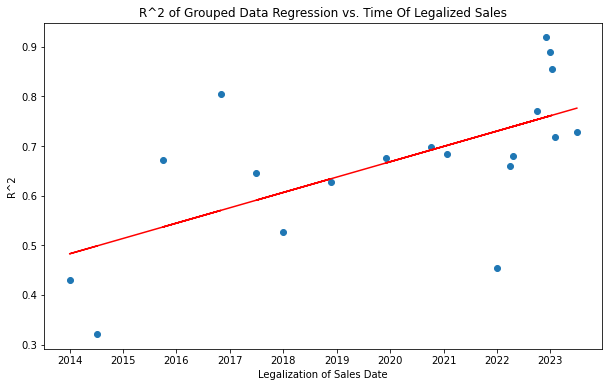

0.3957121087569754


In [30]:
data_x = results_df_grouped['licensed_sales_since_date'].astype("int64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df_grouped['R^2'])

plt.figure(figsize = (10, 6))
plt.scatter(results_df_grouped['licensed_sales_since_date'], results_df_grouped['R^2'])
plt.plot(results_df_grouped['licensed_sales_since_date'], model2.predict(data_x), 'r')
plt.title("R^2 of Grouped Data Regression vs. Time Of Legalized Sales")
plt.xlabel("Legalization of Sales Date")
plt.ylabel("R^2")
plt.savefig("../figures/r2_vs_time_grouped.png", format = 'png', dpi = 300)
print(model2.score(data_x, results_df_grouped['R^2']))

In [76]:
#seperate out "Western" from "non-Western" states in the results dataframes

results_df_grouped = results_df_grouped.reset_index()
results_df_grouped['Western?'] = results_df_grouped.reset_index()['state'].apply(lambda s : s in {"California", "Oregon", "Washington", "Nevada", "Montana", "Colorado", "New Mexico", "Arizona", "Alaska"})
results_df = results_df.reset_index()
results_df['Western?'] = results_df.reset_index()['state'].apply(lambda s : s in {"California", "Oregon", "Washington", "Nevada", "Montana", "Colorado", "New Mexico", "Arizona", "Alaska"})

c:\Users\kdugg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


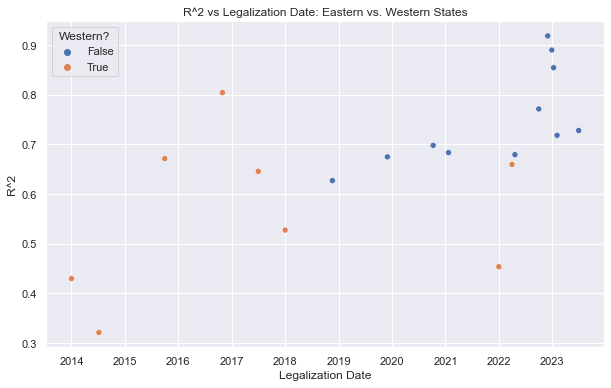

In [79]:
# plot R^2 vs legalization date for the Eastern vs. Western states

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})

ax = sns.scatterplot('licensed_sales_since_date','R^2', hue = "Western?", data = results_df_grouped)
ax.set_title("R^2 vs Legalization Date: Eastern vs. Western States")
ax.set_xlabel("Legalization Date")

plt.savefig("../figures/eastern_vs_western.png", format = 'png', dpi = 300)

0.007531334557545399


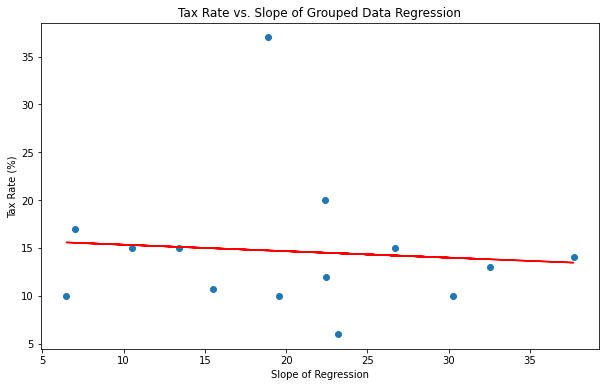

In [164]:
data_x = results_df_tax_grouped['slope'].astype("float64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df_tax_grouped['tax_rate'])
plt.figure(figsize = (10, 6))
plt.scatter(data_x, results_df_tax_grouped['tax_rate'])
plt.plot(data_x, model2.predict(data_x), 'r')
plt.title("Tax Rate vs. Slope of Grouped Data Regression")
plt.xlabel("Slope of Regression")
plt.ylabel("Tax Rate (%)")
plt.savefig("../figures/slope_vs_tax_grouped.png", format = 'png', dpi = 300)
print(model2.score(data_x, results_df_tax_grouped['tax_rate']))
plt.show()


C:\Users\kdugg\AppData\Local\Temp\ipykernel_271028\1436014240.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percent['thc'] = percent['thc'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))* percent['weight'] / 100000


<AxesSubplot:>

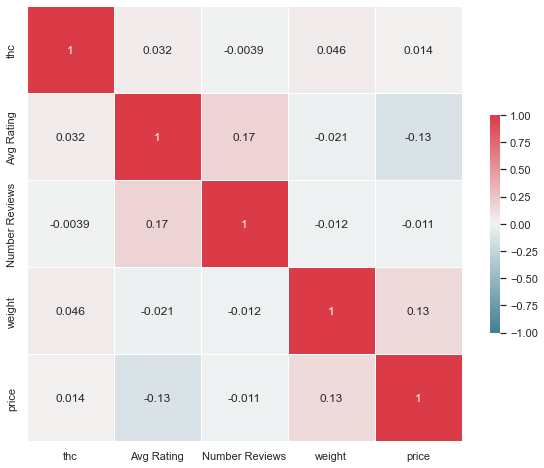

In [212]:
#Correlation matrix on full data


numerical_data = products[['category', 'thc', 'Avg Rating', 'Number Reviews', 'weight', 'price']].query("thc != 'None' & price != 'None' & weight != 'None'")
numerical_data['Number Reviews'] = numerical_data['Number Reviews'].apply(lambda s : s.replace(" reviews", "").replace("1 review", "1").replace(",", "")).astype("float64")
numerical_data['weight'] = numerical_data['weight'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))
numerical_data['price'] = numerical_data['price'].apply(lambda s : float(s[1:]))
percent = numerical_data[numerical_data['thc'].str.contains('%')]
percent['thc'] = percent['thc'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))* percent['weight'] / 100000
numerical_data['thc'] = numerical_data['thc'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))
numerical_data.loc[percent.index, "thc"] = percent['thc']

f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    numerical_data.corr(),          # The data to plot
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=1,       # The maximum value of the legend. All higher vals will be same color
    vmin=-1,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)
#numerical_data[~numerical_data['Number Reviews'].str.contains("reviews")]['Number Reviews'].unique()

76895


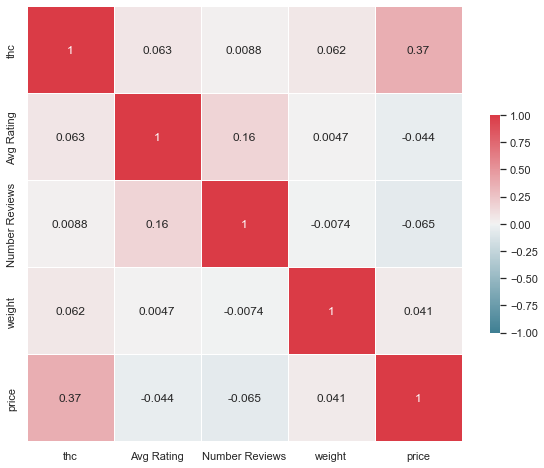

In [256]:
#Correlation matrix for products in specific category

category  = "CONCENTRATES"
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    numerical_data.query(f"category == '{category}'")[['thc', 'Avg Rating', 'Number Reviews', 'weight', 'price']].corr(),          # The data to plot
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=1,       # The maximum value of the legend. All higher vals will be same color
    vmin=-1,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

In [234]:
# Create table of the percent of stores in the Weedmaps data which have some product data 

product_counts = products.groupby("Store Name").first()[['State']].reset_index().groupby("State").count()
store_counts = df4.groupby("State").count()[['Store Name']]
combo = store_counts.join(product_counts, lsuffix= "_total").fillna(0)
combo['percent'] = combo['Store Name']/combo['Store Name_total']

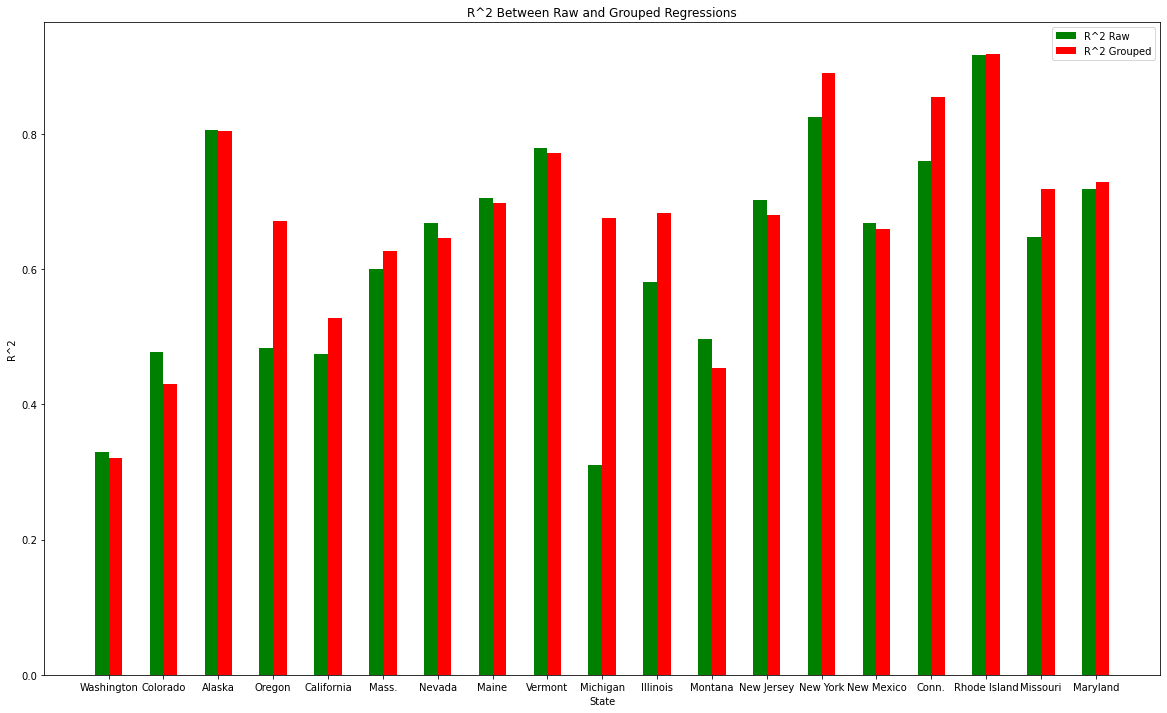

In [59]:
# Bar chart of R^2 between grouped and raw regressions

compare = results_df_grouped[['R^2']].join(results_df[['R^2']], rsuffix = " original")

N = len(compare)
ind = np.arange(N)  
width = 0.25
  
plt.figure(figsize = (20, 12))
  
yvals = compare['R^2 original'].to_numpy()
bar2 = plt.bar(ind, yvals, width, color='g') 

xvals = compare['R^2'].to_numpy()
bar1 = plt.bar(ind+width, xvals, width, color = 'r') 

    
plt.xlabel("State") 
plt.ylabel('R^2') 
plt.title("R^2 Between Raw and Grouped Regressions") 
  
states = list(compare.index)
states[5] = "Mass."
states[15] = "Conn."

plt.xticks(ind+(width/2), states) 
plt.legend((bar2, bar1), ('R^2 Raw', 'R^2 Grouped') ) 
plt.show() 

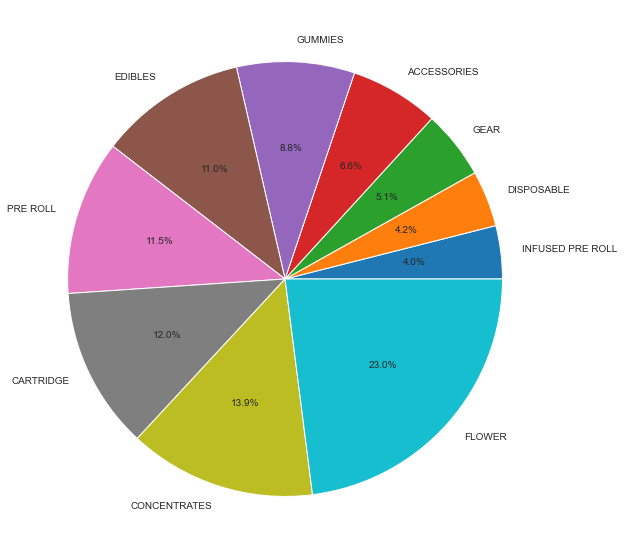

In [74]:
#Pie chart of percent of major product categories

counts = products.groupby("category").count()[['name']].reset_index().sort_values(by = 'name')

sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(10, 10))
plt.pie(counts.tail(10)['name'], labels = counts.tail(10)['category'], autopct='%1.1f%%')
plt.savefig("../figures/pie_chart.png", format = 'png', dpi = 300)